In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import umap
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from umap import UMAP
import umap
import requests  
import json      

In [2]:
#import pandas as pd

df = pd.read_csv("../data/Dataset.csv", encoding="utf-8-sig")  # handles BOM

print(df.columns)
df.info()
df.head(2)


Index(['Category', 'Text'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  13389 non-null  object
 1   Text      13389 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


Category                                               Text
0  Accountant  ﻿________________\r\n\r\nEDUCATION\r\nOMBA - E...
1  Accountant  ﻿________________\r\n\r\nHOWARD GERRARD\r\nAcc...

In [3]:
# Create a new, cleaned DataFrame that EXCLUDES the placeholder resumes.

df_copy = df[~df['Text'].str.contains('lorem|ipsum', case=False, na=False)].copy()

print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_copy)}")

Original dataset size: 13389
Cleaned dataset size: 13322


In [4]:
# 4) Adding a stable resume_id for tracking (optional but helpful for embeddings later)
df = df_copy.copy()
df['Resume_id'] = pd.util.hash_pandas_object(df['Text'], index=False).astype(str)


In [5]:
#import re

# Simple email/phone/URL detectors to understand privacy exposure.
email_rx = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
phone_rx = re.compile(r"\+?\d[\d\-\s]{7,}\d")   # loose, ok for a quick scan
url_rx   = re.compile(r"https?://\S+|www\.\S+")

df["has_email"] = df["Text"].str.contains(email_rx)
df["has_phone"] = df["Text"].str.contains(phone_rx)
df["has_url"]   = df["Text"].str.contains(url_rx)

pii_summary = (df[["has_email","has_phone","has_url"]].mean()*100).round(1).to_dict()
pii_summary


{'has_email': 90.6, 'has_phone': 58.9, 'has_url': 13.0}

In [6]:
print("Number of resumes:", len(df))
print("Columns:", df.columns.tolist())

Number of resumes: 13322
Columns: ['Category', 'Text', 'Resume_id', 'has_email', 'has_phone', 'has_url']


In [7]:
category_counts = df['Category'].value_counts()
print("\nResumes per category:\n", category_counts)


Resumes per category:
 Category
Education                    407
Electrical Engineering       383
Mechanical Engineer          382
Consultant                   366
Civil Engineer               363
Sales                        363
Management                   361
Human Resources              360
Digital Media                354
Java Developer               348
Accountant                   346
Building and Construction    345
Testing                      344
Operations Manager           343
Architecture                 342
Aviation                     340
Finance                      339
SQL Developer                338
Business Analyst             338
Public Relations             336
Health and Fitness           330
Network Security Engineer    330
DotNet Developer             328
Arts                         328
Apparel                      319
Banking                      314
Automobile                   312
SAP Developer                304
Web Designing                304
Data Scien

In [8]:
df['char_count'] = df['Text'].apply(len)  # characters
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))  # words

print("\nCharacter count stats:")
print(df['char_count'].describe())  # min, max, mean, quartiles

print("\nWord count stats:")
print(df['word_count'].describe())


Character count stats:
count    13322.000000
mean      4810.783291
std       3218.304536
min         74.000000
25%       2413.000000
50%       4129.000000
75%       6297.000000
max      70035.000000
Name: char_count, dtype: float64

Word count stats:
count    13322.000000
mean       655.713632
std        442.357376
min          8.000000
25%        327.000000
50%        564.000000
75%        850.000000
max       9735.000000
Name: word_count, dtype: float64


In [9]:
print("\nShortest resumes (by word count):")
display(df.nsmallest(3, 'word_count')[['Category', 'word_count', 'Text']])

print("\nLongest resumes (by word count):")
display(df.nlargest(3, 'word_count')[['Category', 'word_count', 'Text']])


Shortest resumes (by word count):


Category  word_count  \
2892         Agriculture           8   
134             Advocate           9   
5227  Operations Manager           9   

                                                   Text  
2892  ﻿________________\r\n\r\nAgriculture and Natur...  
134   ﻿________________\r\n\r\nGLENN A.LYNN\r\nBRAND...  
5227  ﻿________________\r\n\r\nGary White\r\nOperati...


Longest resumes (by word count):


Category  word_count  \
7423  Blockchain        9735   
6649        Arts        6506   
6776        Arts        6506   

                                                   Text  
7423  ﻿________________\r\n\r\nJESSICA CLAIRE\r\n100...  
6649  ﻿________________\r\n\r\nJESSICA CLAIRE\r\n°\r...  
6776  ﻿________________\r\n\r\nJESSICA CLAIRE\r\n°\r...

In [10]:
dup_count = df.duplicated(subset='Text').sum()
print(f"\nNumber of exact duplicate resumes: {dup_count}")


Number of exact duplicate resumes: 1211


In [11]:
# 6) Checking for possible PII (simple regex for emails and phone numbers)
#import re

def contains_email(text):
    return bool(re.search(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', text))

def contains_phone(text):
    return bool(re.search(r'\+?\d[\d\-\s]{7,}\d', text))  # loose phone match

df['has_email'] = df['Text'].apply(contains_email)
df['has_phone'] = df['Text'].apply(contains_phone)


print("Resumes with emails:", df['has_email'].sum())
print("Resumes with phone numbers:", df['has_phone'].sum())

Resumes with emails: 12076
Resumes with phone numbers: 7840


In [12]:
print("\nSample resumes after cleaning:\n")
for i, row in df.sample(3, random_state=42).iterrows():
    print("—", row["Category"], "| Words:", row["word_count"])
    print(row["Text"][:400], "\n")


Sample resumes after cleaning:

— DevOps | Words: 761
﻿________________

SUMMARY
TECHNICAL SKILLS Ò
AND TOOLS SUMMARY
Jessica Claire
100 Montgomery St. 10th Floor (555) 432-1000 4 resumesample@example.com
Highly skilled DevOps and Cloud Engineer with over 6 years of experience in designing, implementing, and managing large-scale infrastructure and applications in cloud environments. Proficient in automating workflows, optimizing performance, a 

— Mechanical Engineer | Words: 408
﻿________________

CARLEE TRANTOW
1751 Anibal Ridges, Los Angeles, CA
.
+1 (555) 969 2573
WORK EXPERIENCE
MECHANICAL ENGINEER
Detroit, MI
⚫ Determines the technical feasibility of new product concepts and product redesigns to existing products
⚫ Generates, accumulates, and disseminates technical data on products needed by internal and external customers
12/2016 - PRESENT
• Establishes  

— SQL Developer | Words: 859
﻿________________

SUMMARY
Jessica Claire
100 Montgomery St. 10th Floor (555) 432-1000
resumes

In [13]:
# High-level shape and category mix.
Cat_counts = df["Category"].value_counts()
display(Cat_counts.to_frame("count").assign(pct=(Cat_counts/len(df)).round(3)))


count    pct
Category                               
Education                    407  0.031
Electrical Engineering       383  0.029
Mechanical Engineer          382  0.029
Consultant                   366  0.027
Civil Engineer               363  0.027
Sales                        363  0.027
Management                   361  0.027
Human Resources              360  0.027
Digital Media                354  0.027
Java Developer               348  0.026
Accountant                   346  0.026
Building and Construction    345  0.026
Testing                      344  0.026
Operations Manager           343  0.026
Architecture                 342  0.026
Aviation                     340  0.026
Finance                      339  0.025
SQL Developer                338  0.025
Business Analyst             338  0.025
Public Relations             336  0.025
Health and Fitness           330  0.025
Network Security Engineer    330  0.025
DotNet Developer             328  0.025
Arts                         328  0.025
Apparel                      319  0.024
Banking                      314  0.024
Automobile                   312  0.023
SAP Developer                304  0.023
Web Designing                304  0.023
Data Science                 297  0.022
ETL Developer                294  0.022
Advocate                     290  0.022
Agriculture                  290  0.022
DevOps                       289  0.022
PMO                          286  0.021
Information Technology       272  0.020
Database                     257  0.019
Python Developer             248  0.019
Designing                    239  0.018
BPO                          202  0.015
React Developer              182  0.014
Food and Beverages           162  0.012
Blockchain                    47  0.004

Sample of Extracted Skills for Accountants:
                                                Text  \
0  ﻿________________\r\n\r\nEDUCATION\r\nOMBA - E...   
1  ﻿________________\r\n\r\nHOWARD GERRARD\r\nAcc...   
2  ﻿________________\r\n\r\nKevin Frank\r\nSENIOR...   
3  ﻿________________\r\n\r\nPlace of birth\r\nNat...   
4  ﻿________________\r\n\r\nStephen Greet, CPA\r\...   

                                    extracted_skills  
0  [Hyperion, Oracle, CMA, QuickBooks, Financial ...  
1                                          [Payroll]  
2  [Accounts Receivable, Accounts Payable, QuickB...  
3  [Internal Audit, Certified Public Accountant, ...  
4  [Certified Public Accountant, CPA, Financial R...  


--- Top 15 Most Common Skills for Accountants ---
                  Skill  Count
8               Payroll    201
10     Accounts Payable    178
11       General Ledger    175
3            QuickBooks    147
9   Accounts Receivable    124
14  Financial Reporting    124
18                 G

/var/folders/k7/w3wlkgdj2bdd17bdg7w4fvdc0000gn/T/ipykernel_99113/420458552.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skill_counts_df.head(top_n), palette='viridis', ax=ax)


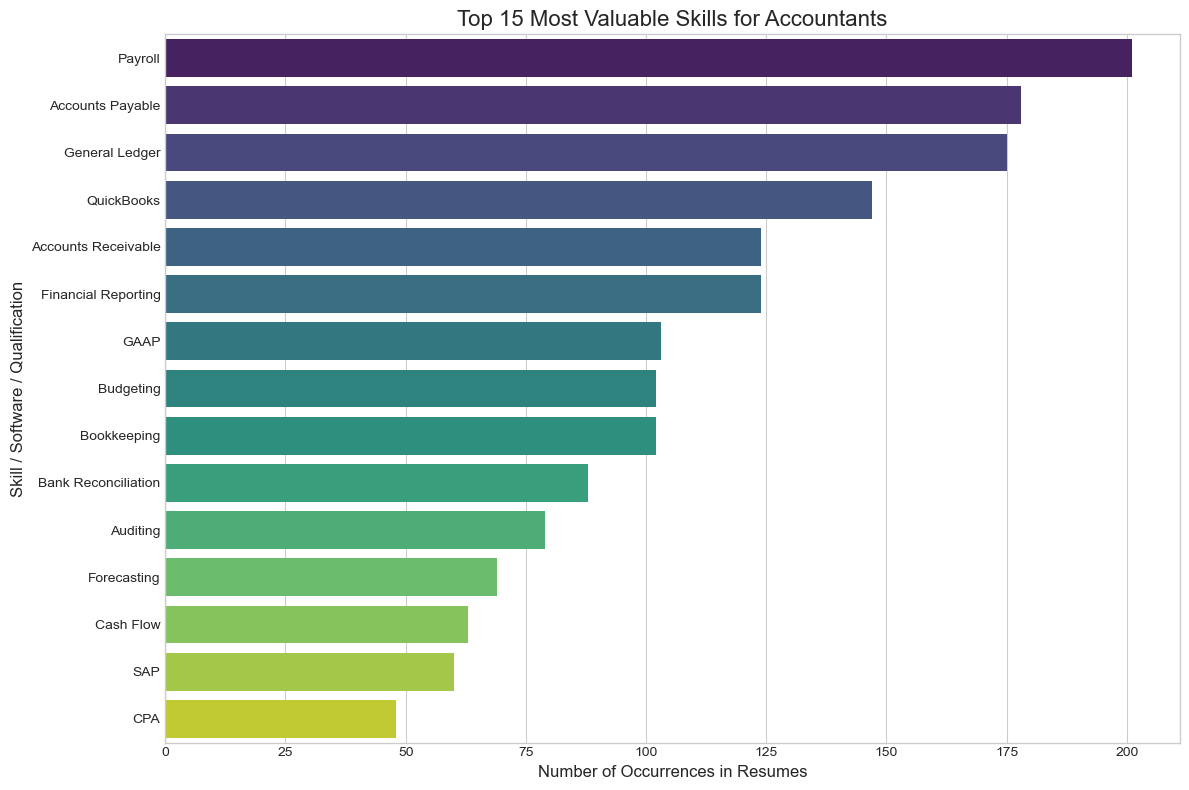

In [14]:

ACCOUNTANT_KEYWORDS = {
    "Software & ERPs": [
        r'\bSAP\b', r'\bOracle\b', r'NetSuite', r'Microsoft Dynamics',
        r'QuickBooks', r'\bXero\b', r'\bSage\b', r'FreshBooks',
        r'Hyperion', r'Anaplan', r'Adaptive Insights', r'Pivot Tables',
        r'VLOOKUP', r'XLOOKUP', r'\bMacros\b', r'\bVBA\b', r'Financial Modeling',
        r'Tableau', r'Power BI'
    ],
    "Technical Skills": [
        r'Accounts Payable', r'\bAP\b', r'Accounts Receivable', r'\bAR\b',
        r'General Ledger', r'\bGL\b', r'Bookkeeping', r'Payroll',
        r'Bank Reconciliation', r'Month-End Close', r'Year-End Close',
        r'Financial Reporting', r'Financial Statement Analysis',
        r'Budgeting', r'Forecasting', r'Variance Analysis',
        r'Cash Flow', r'\bGAAP\b', r'\bIFRS\b', r'\bSOX\b', r'Sarbanes-Oxley',
        r'Taxation', r'Auditing', r'Internal Audit', r'Cost Accounting'
    ],
    "Certifications": [
        r'\bCPA\b', r'Certified Public Accountant', r'\bCMA\b', r'Certified Management Accountant',
        r'\bACCA\b', r'\bCFA\b', r'Chartered Financial Analyst', r'\bEA\b', r'Enrolled Agent',
        r'\bCIA\b', r'Certified Internal Auditor'
    ]
}

#  Creating the Extraction Function

def extract_keywords(Text, keywords_dict):
    found_keywords = set()
    if not isinstance(Text, str):
        return [] # Return empty list if text is not a string (e.g., NaN)

    for category, patterns in keywords_dict.items():
        for pattern in patterns:
            if re.search(pattern, Text, re.IGNORECASE):
                # Store a clean version of the keyword, e.g., 'CPA' instead of r'\bCPA\b'
                clean_pattern = re.sub(r'\\b', '', pattern)
                found_keywords.add(clean_pattern)
    return list(found_keywords)



# Filter for only the 'Accountant' resumes
accountant_df = df[df['Category'] == 'Accountant'].copy()

# Apply the extraction function to each resume
accountant_df['extracted_skills'] = accountant_df['Text'].apply(
    lambda text: extract_keywords(text, ACCOUNTANT_KEYWORDS)
)

print("Sample of Extracted Skills for Accountants:")
print(accountant_df[['Text', 'extracted_skills']].head())
print("\n" + "="*50 + "\n")


# Analyze Skill Frequency 

# Flatten the list of lists into a single list of all skills found
all_skills = [skill for sublist in accountant_df['extracted_skills'] for skill in sublist]

# Count the frequency of each skill
skill_counts = Counter(all_skills)

# Convert to a DataFrame for easier plotting
skill_counts_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

print("--- Top 15 Most Common Skills for Accountants ---")
print(skill_counts_df.head(15))
print("\n" + "="*50 + "\n")


# Analyze Certification Prevalence 

# Check for the presence of a CPA certification
accountant_df['has_cpa'] = accountant_df['extracted_skills'].apply(
    lambda skills: 'CPA' in skills or 'Certified Public Accountant' in skills
)

cpa_percentage = (accountant_df['has_cpa'].sum() / len(accountant_df)) * 100

print(f"--- Certification Analysis ---")
print(f"Percentage of accountant resumes with CPA certification: {cpa_percentage:.2f}%")
print("\n" + "="*50 + "\n")


# Visualizing the Results

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the top 15 skills
top_n = 15
sns.barplot(x='Count', y='Skill', data=skill_counts_df.head(top_n), palette='viridis', ax=ax)

ax.set_title(f'Top {top_n} Most Valuable Skills for Accountants', fontsize=16)
ax.set_xlabel('Number of Occurrences in Resumes', fontsize=12)
ax.set_ylabel('Skill / Software / Qualification', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Sample of Extracted Skills for Engineers:
                                                   Text extracted_skills
1919  ﻿________________\r\n\r\nCAMILA CIENFUEGOS\r\n...               []
1920  ﻿________________\r\n\r\nEmail:\r\nabc@xyz.com...               []
1921  ﻿________________\r\n\r\nDaniel Gordts\r\n• Ph...               []
1922  ﻿________________\r\n\r\nSenior Mechanical Eng...               []
1923  ﻿________________\r\n\r\nEXPERIENCE\r\nKody Br...               []


--- Top 15 Most Common Skills for Engineers ---
                  Skill  Count
5                   SAP     13
9             Budgeting     12
10                   AR      6
0        Internal Audit      5
2                   VBA      5
3                    GL      3
7                Oracle      3
11          Forecasting      3
12                   AP      3
13                  CMA      3
1                Macros      2
4   Accounts Receivable      2
8                  Sage      2
14            Cash Flow      2
6    

/var/folders/k7/w3wlkgdj2bdd17bdg7w4fvdc0000gn/T/ipykernel_99113/1415885798.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skill_counts_df.head(top_n), palette='viridis', ax=ax)


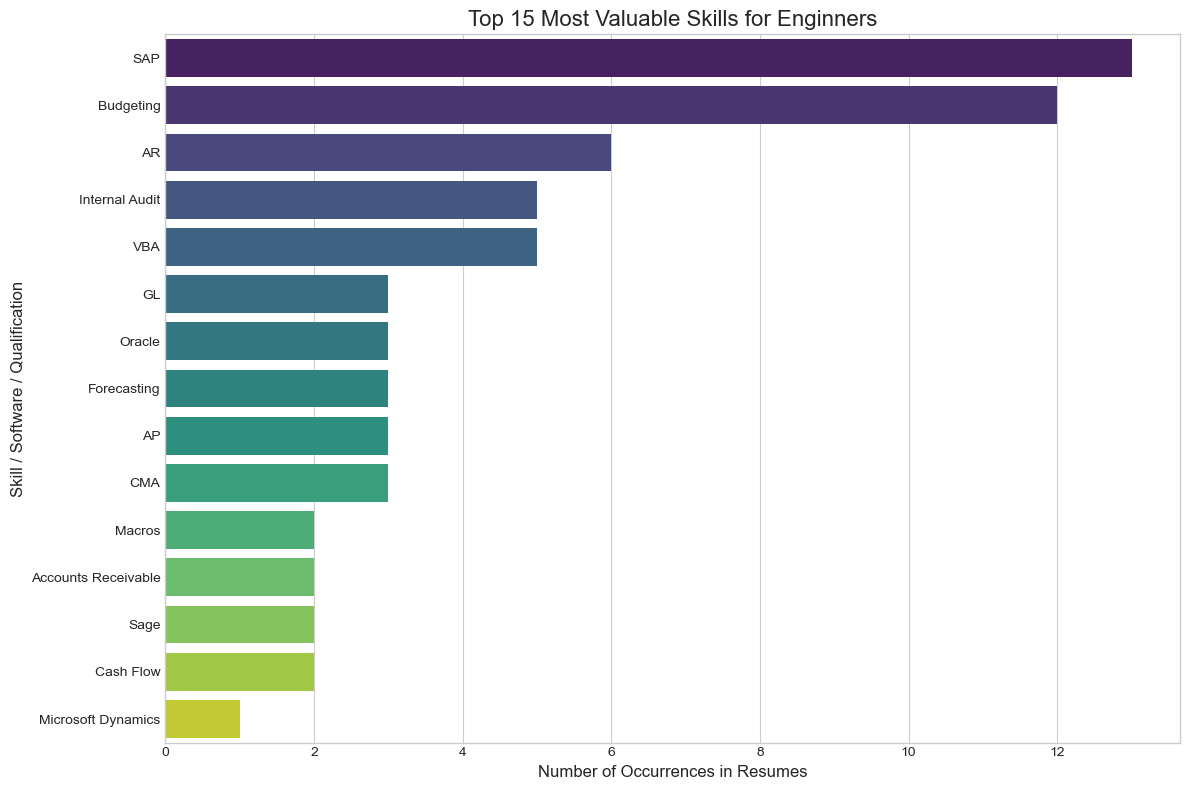

In [15]:

ENGINEER_KEYWORDS = {
    "Software & Tools": [
        r'\bSolidWorks\b', r'\bCATIA\b', r'\bCreo\b', r'\bSiemens NX\b', r'AutoCAD',
        r'\bANSYS\b', r'Abaqus', r'Finite Element Analysis', r'\bFEA\b', r'\bCFD\b',
        r'\bMATLAB\b', r'\bSimulink\b', r'\bLabVIEW\b', r'\bPSpice\b', r'\bLTspice\b',
        r'Altium Designer', r'\bKiCad\b', r'\bEagle\b', r'PCB Layout', r'PCB Design',
        r'\bAltium\b', r'\bCadence\b', r'\bOrCAD\b', r'\bCOMSOL\b', r'\bANSYS Fluent\b',
        r'\bPython\b', r'\bC\b', r'\bC\+\+\b', r'\bEmbedded C\b', r'\bSimscape\b',
        r'\bSolid Edge\b', r'\bFusion 360\b', r'\bOnshape\b', r'\bHyperWorks\b'
    ],
    "Technical Skills": [
        r'Mechanical Design', r'Product Design', r'3D Modeling', r'Parametric Design',
        r'Tolerance Analysis', r'Geometric Dimensioning and Tolerancing', r'\bGD&T\b',
        r'Stress Analysis', r'Structural Analysis', r'Vibration Analysis', r'Modal Analysis',
        r'Fatigue Analysis', r'Heat Transfer', r'Thermodynamics', r'Fluid Mechanics',
        r'Hydraulics', r'Pneumatics', r'Control Systems', r'PID Control', r'System Dynamics',
        r'Power Electronics', r'Motor Control', r'PWM', r'Inverter', r'Converters',
        r'Battery Management System', r'\bBMS\b', r'Circuit Design', r'Analog Design',
        r'Digital Design', r'Embedded Systems', r'Firmware', r'FPGA', r'\bVHDL\b', r'\bVerilog\b',
        r'Signal Processing', r'Noise Reduction', r'EMC', r'EMI', r'Test & Measurement',
        r'\bOscilloscope\b', r'\bMultimeter\b', r'\bSpectrum Analyzer\b', r'Soldering',
        r'PCB Assembly', r'\bSMT\b', r'BOM Management', r'DFM', r'DFT', r'Root Cause Analysis'
    ],
    "Manufacturing & Fabrication": [
        r'\bCNC\b', r'Machining', r'Turning', r'Milling', r'EDM', r'Grinding',
        r'Additive Manufacturing', r'3D Printing', r'SLA', r'SLS', r'\bFDM\b',
        r'Injection Molding', r'Sheet Metal', r'Stamping', r'Welding', r'TIG', r'MIG',
        r'Laser Cutting', r'Forging', r'Casting', r'Assembly Processes', r'Lean Manufacturing',
        r'\bSix Sigma\b', r'Kaizen', r'Process Optimization', r'Quality Control', r'Inspection',
        r'Nondestructive Testing', r'\bNDT\b', r'Coordinate Measuring Machine', r'\bCMM\b'
    ],
    "Standards & Certifications": [
        r'\bASME\b', r'\bISO\b', r'\bISO\s?9001\b', r'\bANSI\b', r'\bIEEE\b', r'\bIEC\b',
        r'\bUL\b', r'\bCE\b', r'\bRoHS\b', r'\bIPC\b', r'IPC-A-610', r'\bPE\b', r'\bFE\b',
        r'\bEIT\b', r'\bChartered Engineer\b', r'\bCEng\b', r'\bCertified LabVIEW Developer\b',
        r'\bNFPA\b', r'\bNEMA\b', r'\bATEX\b', r'\bCSA\b', r'\bIP Rating\b', r'\bMIL-STD\b',
        r'\bRoHS\b', r'\bREACH\b', r'\bCSA\b', r'\bOSHA\b'
    ]
}

#  Creating the Extraction Function

def extract_keywords(Text, keywords_dict):
    found_keywords = set()
    if not isinstance(Text, str):
        return [] # Return empty list if text is not a string (e.g., NaN)

    for category, patterns in keywords_dict.items():
        for pattern in patterns:
            if re.search(pattern, Text, re.IGNORECASE):
                # Store a clean version of the keyword, e.g., 'CPA' instead of r'\bCPA\b'
                clean_pattern = re.sub(r'\\b', '', pattern)
                found_keywords.add(clean_pattern)
    return list(found_keywords)



# Filter for only the 'Engineer' resumes
engineer_df = df[(df['Category'] == 'Mechanical Engineer') | (df['Category'] == 'Electrical Engineer')].copy()

# Apply the extraction function to each resume
engineer_df['extracted_skills'] = engineer_df['Text'].apply(
    lambda text: extract_keywords(text, ACCOUNTANT_KEYWORDS)
)

print("Sample of Extracted Skills for Engineers:")
print(engineer_df[['Text', 'extracted_skills']].head())
print("\n" + "="*50 + "\n")


# Analyze Skill Frequency 

# Flatten the list of lists into a single list of all skills found
all_skills = [skill for sublist in engineer_df['extracted_skills'] for skill in sublist]

# Count the frequency of each skill
skill_counts = Counter(all_skills)

# Convert to a DataFrame for easier plotting
skill_counts_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

print("--- Top 15 Most Common Skills for Engineers ---")
print(skill_counts_df.head(15))
print("\n" + "="*50 + "\n")

""""
# Analyze Certification Prevalence 

# Check for the presence of a CPA certification
engineer_df['has_cpa'] = engineer_df['extracted_skills'].apply(
    lambda skills: 'CPA' in skills or 'Certified Public Accountant' in skills
)

cpa_percentage = (engineer_df['has_cpa'].sum() / len(engineer_df)) * 100

print(f"--- Certification Analysis ---")
print(f"Percentage of engineering resumes with CPA certification: {cpa_percentage:.2f}%")
print("\n" + "="*50 + "\n")
"""""

# Visualizing the Results

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the top 15 skills
top_n = 15
sns.barplot(x='Count', y='Skill', data=skill_counts_df.head(top_n), palette='viridis', ax=ax)

ax.set_title(f'Top {top_n} Most Valuable Skills for Enginners', fontsize=16)
ax.set_xlabel('Number of Occurrences in Resumes', fontsize=12)
ax.set_ylabel('Skill / Software / Qualification', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatization function
accountant_df['lemmatized_text'] = accountant_df['Text'].apply(lemmatize_text)

print("--- Text After Lemmatization ---")
print(accountant_df[['Text', 'lemmatized_text']].head())
print("\n" + "="*50 + "\n")

--- Text After Lemmatization ---
                                                Text  \
0  ﻿________________\r\n\r\nEDUCATION\r\nOMBA - E...   
1  ﻿________________\r\n\r\nHOWARD GERRARD\r\nAcc...   
2  ﻿________________\r\n\r\nKevin Frank\r\nSENIOR...   
3  ﻿________________\r\n\r\nPlace of birth\r\nNat...   
4  ﻿________________\r\n\r\nStephen Greet, CPA\r\...   

                                     lemmatized_text  
0  ﻿________________ EDUCATION OMBA - Executive L...  
1  ﻿________________ HOWARD GERRARD Accountant De...  
2  ﻿________________ Kevin Frank SENIOR ACCOUNTAN...  
3  ﻿________________ Place of birth Nationality O...  
4  ﻿________________ Stephen Greet , CPA Senior A...  




In [17]:
accountant_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, 0 to 5935
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Category          346 non-null    object
 1   Text              346 non-null    object
 2   Resume_id         346 non-null    object
 3   has_email         346 non-null    bool  
 4   has_phone         346 non-null    bool  
 5   has_url           346 non-null    bool  
 6   char_count        346 non-null    int64 
 7   word_count        346 non-null    int64 
 8   extracted_skills  346 non-null    object
 9   has_cpa           346 non-null    bool  
 10  lemmatized_text   346 non-null    object
dtypes: bool(4), int64(2), object(5)
memory usage: 23.0+ KB


In [18]:

# Adding domain-specific stop words. Since we are analyzing BAs, words like 'business' or 'analyst' might not help differentiate them.

custom_stop_words = ['accountant', 'accounting', 'financial', 'ledger', 'gaap', 'finance']


vectorizer = TfidfVectorizer(
    max_df=0.9,          # Ignore words that appear in > 90% of documents
    min_df=2,            # Ignore words that appear in less than 2 documents
    stop_words='english',
    
)

tfidf_matrix = vectorizer.fit_transform(accountant_df['lemmatized_text'])
feature_names = vectorizer.get_feature_names_out()

In [19]:


# Looking for 20 distinct topics in our small dataset.
NUM_TOPICS = 20

lda = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    random_state=42
)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=20, random_state=42)

In [20]:

# Display the top words for each topic found by the LDA model.

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top words for this topic
        top_word_indices = topic.argsort()[-num_top_words:]
        # Reverse the order to get the highest probability words first
        top_words = [feature_names[i] for i in top_word_indices][::-1]
        print(f"Topic #{topic_idx + 1}: {' '.join(top_words)}")

print(" Discovered Topics from Resumes ")
display_topics(lda, feature_names, num_top_words=5)
print("\n" + "="*50 + "\n")

 Discovered Topics from Resumes 
Topic #1: delhi gst custom animal chemical
Topic #2: maintain wa job development relationship
Topic #3: fresno faculty buffalo 559 canada
Topic #4: sometown sacramento introductory vt canada
Topic #5: kerala moore importing faculty cancellation
Topic #6: church fpl mas assured salesforce
Topic #7: cork hartford equivalent amp nocona
Topic #8: london havana 999 kickresume langford
Topic #9: alexandria sea nigeria deliverables frontier
Topic #10: account tax customer management report
Topic #11: auckland ncea 64 zealand charleston
Topic #12: ready leverages happiness highest processor
Topic #13: pr driver october gourmet plano
Topic #14: licensing forfeiture convicted intemational technically
Topic #15: dental xxxx audio sample dentist
Topic #16: singapore malaysia plant completes gce
Topic #17: soft underwriting arrangement gaming fullerton
Topic #18: qwikresume documented title board statements
Topic #19: casino 90291 birth 1515 valuations
Topic #20: gr

In [21]:
model = SentenceTransformer('all-MiniLM-L6-v2')

#  Define Helper Functions

def chunk_text(text, chunk_size=6000, chunk_overlap=300): # Splits text into overlapping chunks.
    if not isinstance(text, str):
        return []
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start += chunk_size - chunk_overlap
    return chunks

def get_resume_embedding(resume_text):
    chunks = chunk_text(resume_text) # Chunks a resume, gets embeddings for each chunk, and returns the average vector.
    if not chunks:
        return np.zeros(model.get_sentence_embedding_dimension())
    chunk_embeddings = model.encode(chunks)
    resume_embedding = np.mean(chunk_embeddings, axis=0)
    return resume_embedding

TARGET_CATEGORY = 'Education'  

# Filtering the DataFrame to focus on the chosen category
category_df = df[df['Category'] == TARGET_CATEGORY].copy()
print(f"Found {len(category_df)} resumes for the category: '{TARGET_CATEGORY}'")

# Applying the embedding function to the filtered dataset
print(f"Generating embeddings for '{TARGET_CATEGORY}' resumes...")
category_df['embedding'] = category_df['Text'].apply(get_resume_embedding)
print("Embeddings generated.")


# Apply UMAP and Plot

# Prepare the data for UMAP
resume_vectors = np.array(category_df['embedding'].tolist())

# Initialising UMAP
print("Running UMAP for dimensionality reduction...")
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(resume_vectors)
print("UMAP complete.")

# Creating a DataFrame for plotting
plot_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
plot_df['Text'] = category_df['Text'].values # For hover-over info

# Creating an interactive plot with Plotly

fig = px.scatter(
    plot_df,
    x='x',
    y='y',
    title=f'UMAP Projection of Resume Similarities for "{TARGET_CATEGORY}"',
    hover_data={'x': False, 'y': False, 'Text': True},
    template='plotly_white'
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2",
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    )
)


fig.show()

Found 407 resumes for the category: 'Education'
Generating embeddings for 'Education' resumes...
Embeddings generated.
Running UMAP for dimensionality reduction...


/Users/senuthdias/miniforge3/envs/capstone-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP complete.


In [22]:
import os
os.makedirs("figures", exist_ok=True)

fig.write_image("figures/umap_education_resumes.png", width=1000, height=700, scale=2)
print("Saved: figures/umap_education_resumes.png")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved: figures/umap_education_resumes.png


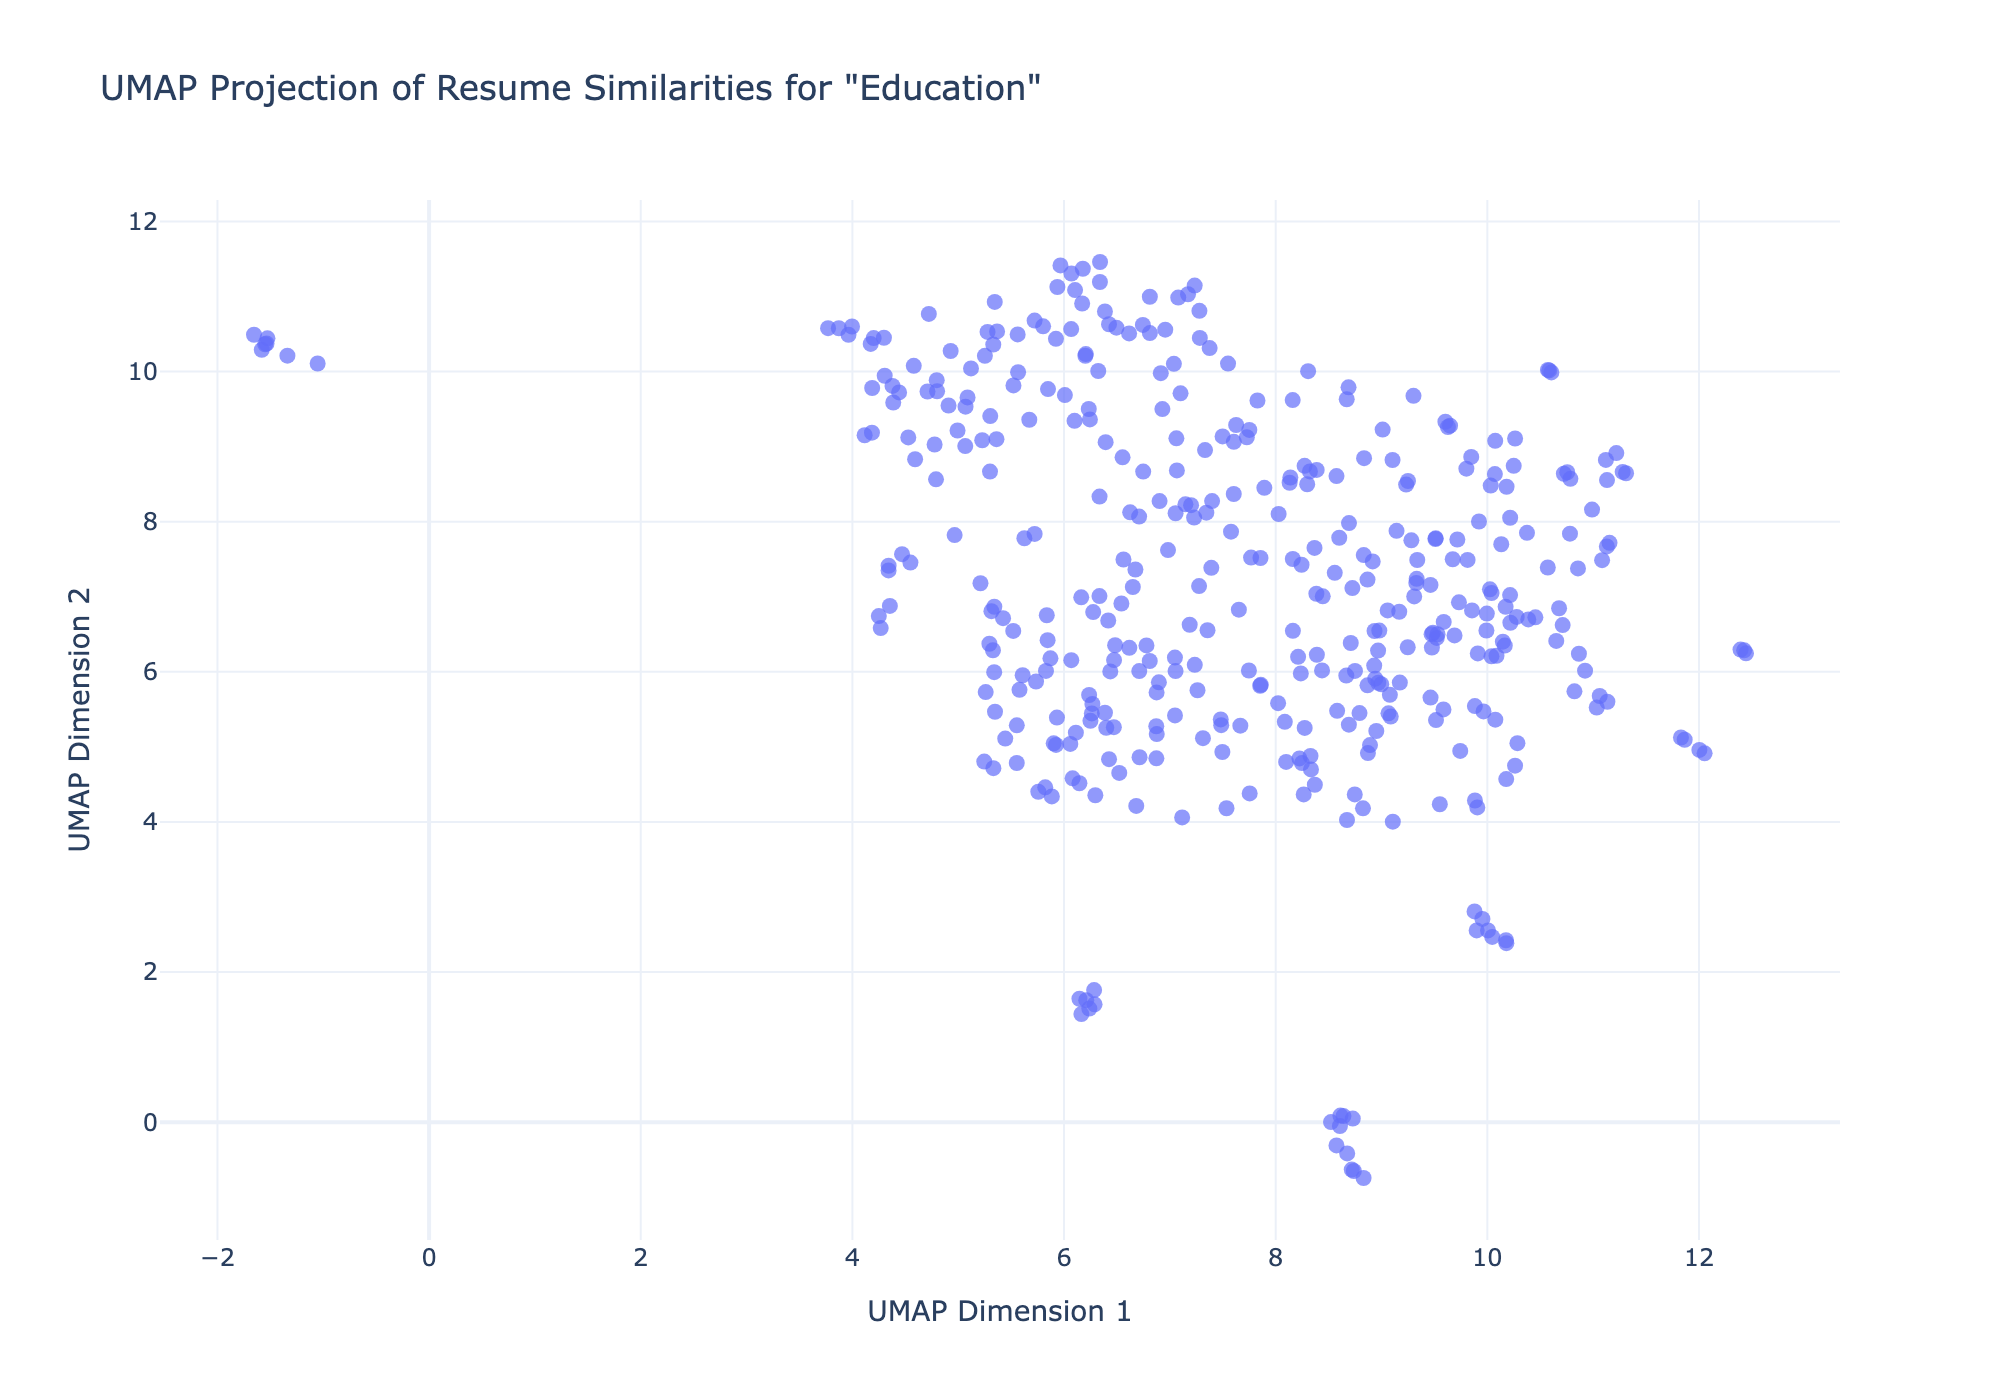

In [23]:
from IPython.display import Image, display

# After saving with fig.write_image
display(Image("figures/umap_education_resumes.png"))

In [24]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Defining Helper Functions 

def chunk_text(text, chunk_size=6000, chunk_overlap=300):
    if not isinstance(text, str):
        return []
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start += chunk_size - chunk_overlap
    return chunks

def get_resume_embedding(resume_text):
    chunks = chunk_text(resume_text)
    if not chunks:
        return np.zeros(model.get_sentence_embedding_dimension())
    chunk_embeddings = model.encode(chunks)
    resume_embedding = np.mean(chunk_embeddings, axis=0)
    return resume_embedding


# Selecting the top 10 categories by volume
top_categories = df['Category'].value_counts().nlargest(10).index
print(f"Analyzing the top categories: {top_categories.tolist()}")

# Filtering the DataFrame to focus on the chosen categories
top_df = df[df['Category'].isin(top_categories)].copy()
print(f"Filtered dataset to {len(top_df)} resumes from the top categories.")

# Applying the embedding function to the filtered dataset
print(f"Generating embeddings for all resumes in the top categories...")
top_df['embedding'] = top_df['Text'].apply(get_resume_embedding)
print("Embeddings generated.")


# Apply UMAP and Plot

# Preparing the data for UMAP
resume_vectors = np.array(top_df['embedding'].tolist())

# Initialising UMAP
print("Running UMAP for dimensionality reduction...")
# We might increase n_neighbors for a larger, more diverse dataset
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(resume_vectors)
print("UMAP complete.")

# Create a DataFrame for plotting
plot_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
plot_df['Category'] = top_df['Category'].values
plot_df['Text'] = top_df['Text'].values

# Create an interactive, color-coded plot

fig = px.scatter(
    plot_df,
    x='x',
    y='y',
    color='Category',  # This is the key change for color-coding!
    title='UMAP Projection of Resume Similarities for Top 10 Job Categories',
    hover_data={'x': False, 'y': False, 'Category': True, 'Text': True},
    labels={'color': 'Job Category'}
)

#fig.update_traces(marker=dict(size=6, opacity=0.8))
#fig.show()

Analyzing the top categories: ['Education', 'Electrical Engineering', 'Mechanical Engineer', 'Consultant', 'Civil Engineer', 'Sales', 'Management', 'Human Resources', 'Digital Media', 'Java Developer']
Filtered dataset to 3687 resumes from the top categories.
Generating embeddings for all resumes in the top categories...
Embeddings generated.
Running UMAP for dimensionality reduction...


/Users/senuthdias/miniforge3/envs/capstone-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP complete.


In [25]:
import os
os.makedirs("figures", exist_ok=True)
fig.write_image("figures/umap_top10_categories.png", width=1200, height=800, scale=2)
print("Saved plot as: figures/umap_top10_categories.png")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved plot as: figures/umap_top10_categories.png


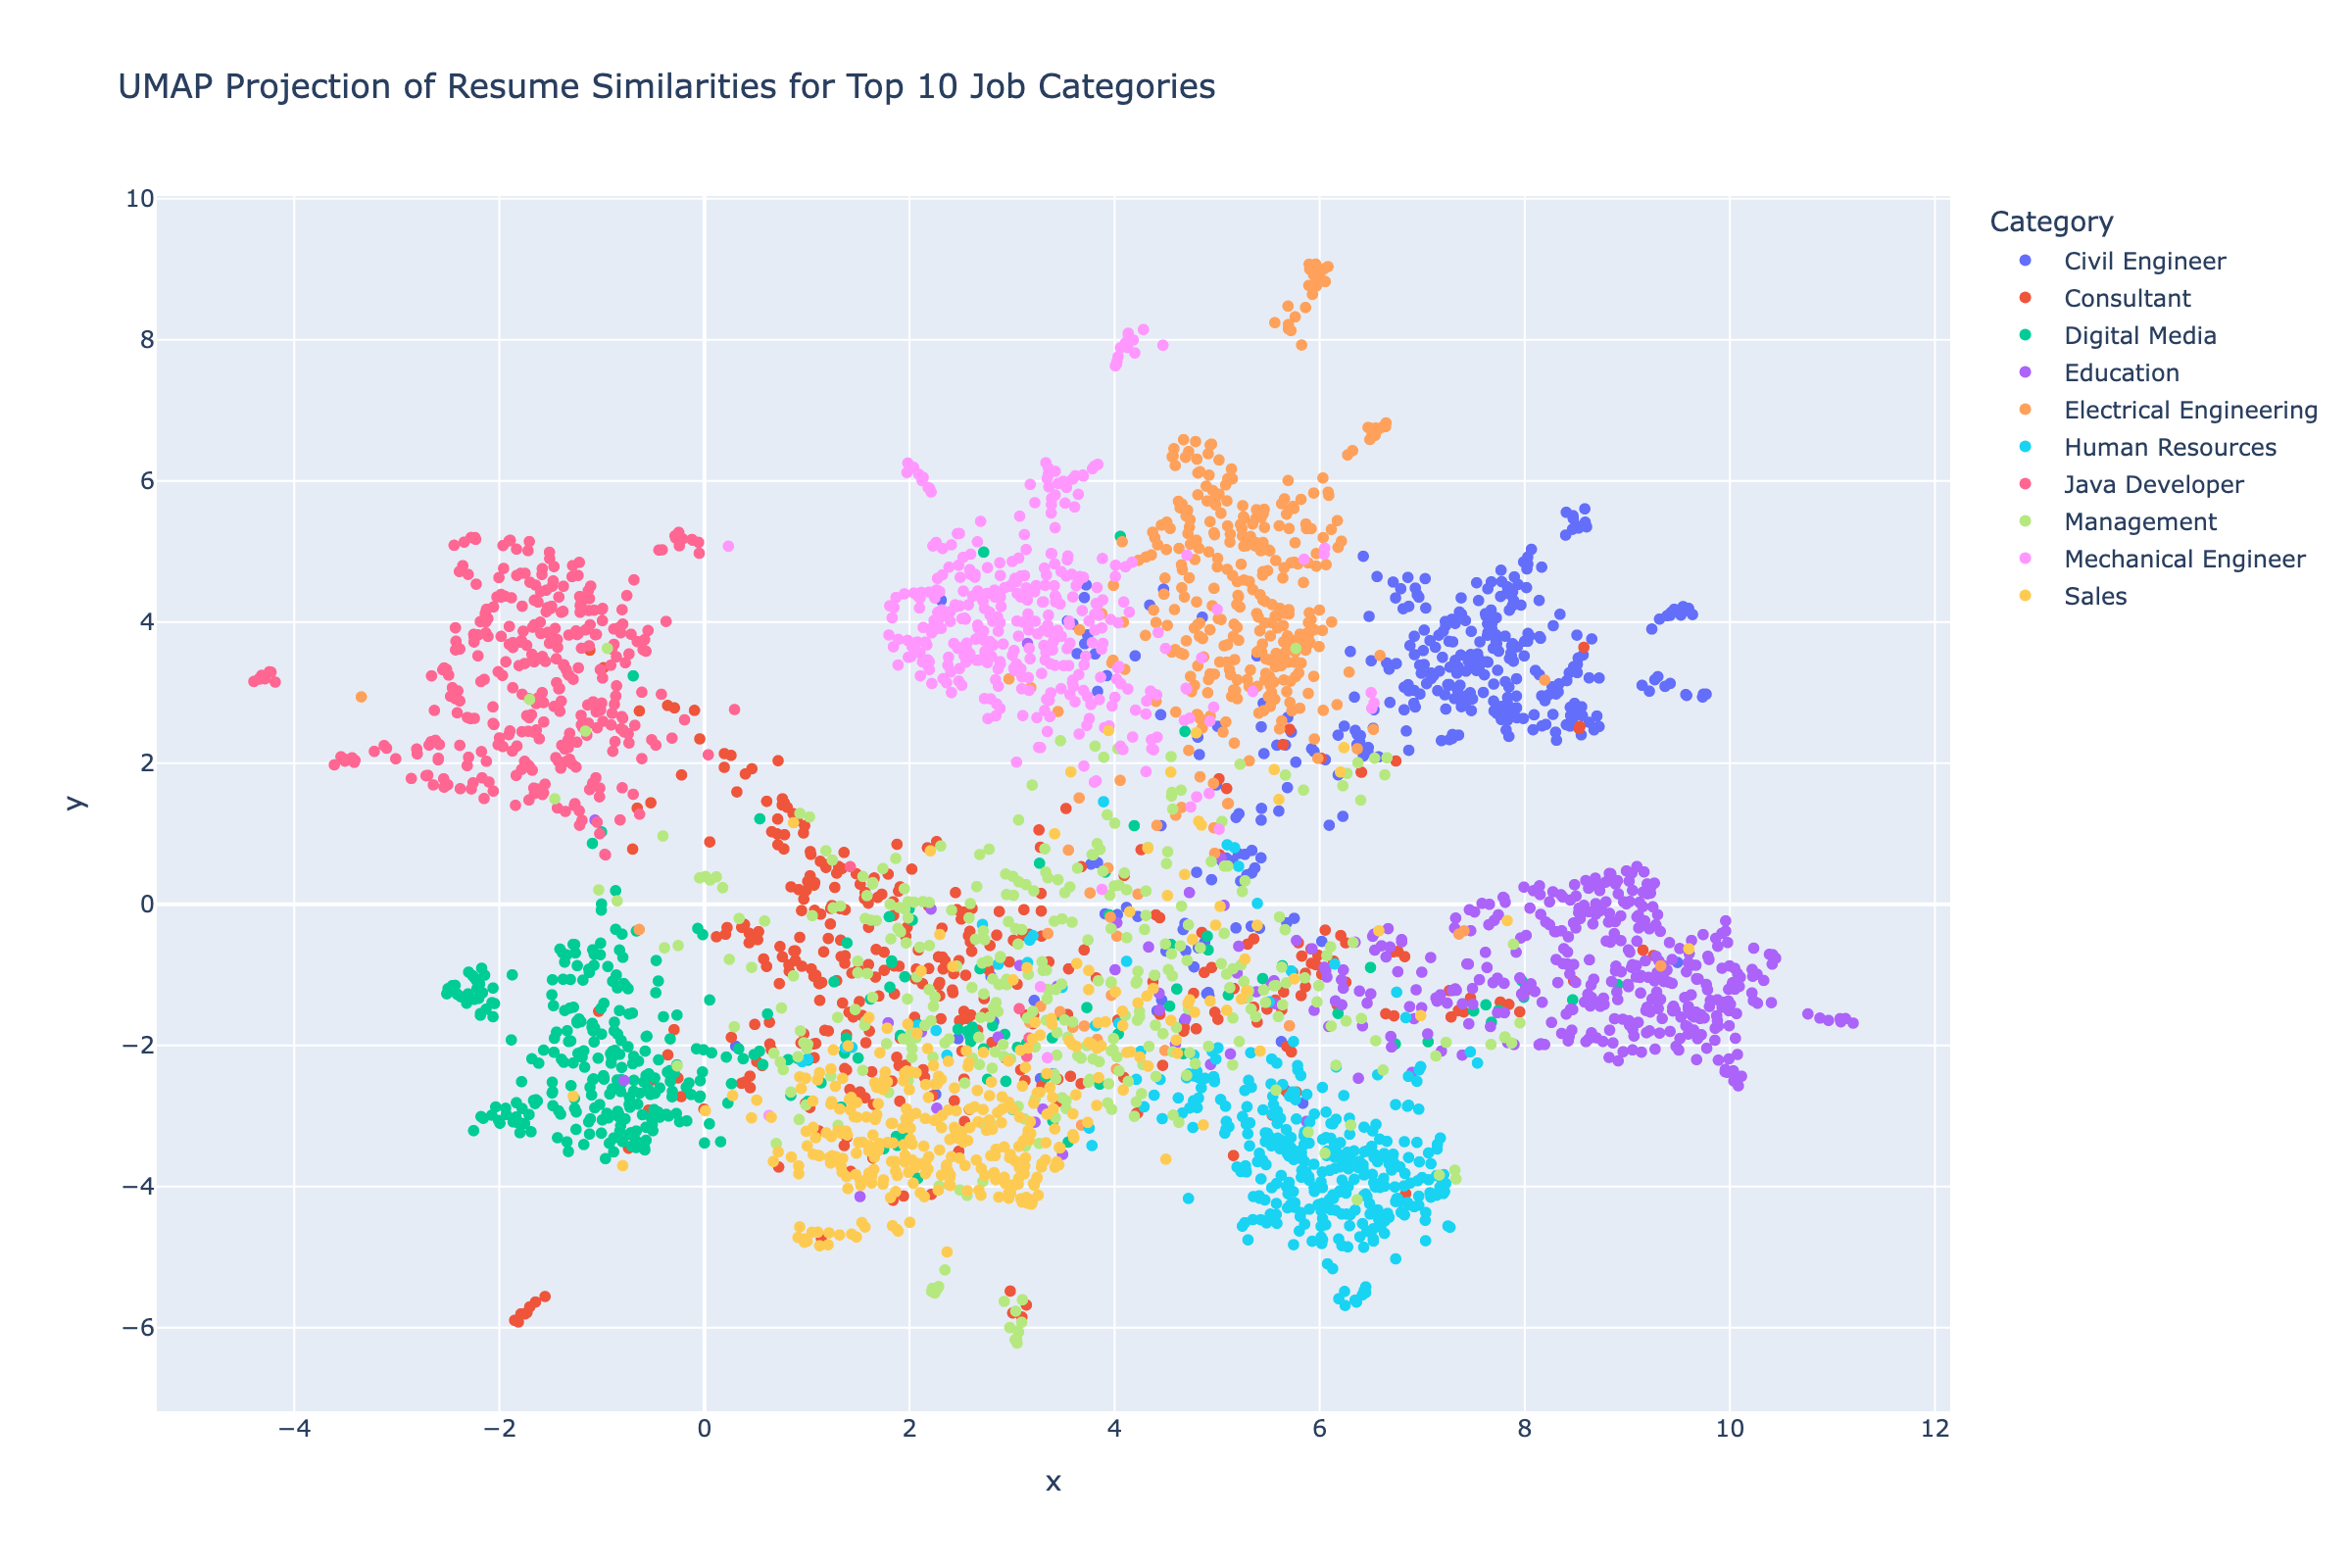

In [26]:
from IPython.display import Image, display
display(Image("figures/umap_top10_categories.png"))

In [27]:
# OLLAMA function
def get_resume_embedding_ollama(resume_text, model_name="nomic-embed-text:latest "):
    chunks = chunk_text(resume_text)
    
    if not chunks:
        # We need to know the embedding dimension. For nomic-embed-text, it's 768.
        return np.zeros(768)
        
    chunk_embeddings = []
    
    # Get embedding for each chunk by calling the Ollama API
    try:
        for chunk in chunks:
            # The API endpoint for Ollama embeddings
            url = "http://localhost:11434/api/embeddings"
            
            # The data payload
            payload = {
                "model": model_name,
                "prompt": chunk
            }
            
            # Making the request
            response = requests.post(url, data=json.dumps(payload))
            response.raise_for_status() # Raise an exception for bad status codes
            
            # Extracting the embedding from the JSON response
            embedding = response.json()["embedding"]
            chunk_embeddings.append(embedding)
            
    except requests.exceptions.RequestException as e:
        print(f"Error calling Ollama API: {e}")
        print("Please make sure the Ollama application is running and you have pulled the model with 'ollama pull nomic-embed-text'")
        # Return a zero vector on error
        return np.zeros(768)

    # Taking the average of the vectors (same as before)
    if not chunk_embeddings:
        return np.zeros(768)
        
    resume_embedding = np.mean(chunk_embeddings, axis=0)
    return resume_embedding

# Defining Helper Functions 
def chunk_text(Text, chunk_size=6000, chunk_overlap=300):
    if not isinstance(Text, str): return []
    chunks = []
    start = 0
    while start < len(Text):
        end = start + chunk_size
        chunks.append(Text[start:end])
        start += chunk_size - chunk_overlap
    return chunks

top_categories = df['Category'].value_counts().nlargest(10).index
top_df = df[df['Category'].isin(top_categories)].copy()


print(f"Generating embeddings for {len(top_df)} resumes using Ollama...")
top_df['embedding'] = top_df['Text'].apply(get_resume_embedding_ollama)
print("Embeddings generated.")

#Apply UMAP and Plot
resume_vectors = np.array(top_df['embedding'].tolist())
print("Running UMAP for dimensionality reduction...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(resume_vectors)
print("UMAP complete.")
plot_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
plot_df['Category'] = top_df['Category'].values
plot_df['Text'] = top_df['Text'].values
#fig = px.scatter(plot_df, x='x', y='y', color='Category', title='UMAP Projection (using Ollama nomic-embed-text)', hover_data={'x': False, 'y': False, 'Category': True, 'Text': True}, labels={'color': 'Job Category'})
#fig.update_traces(marker=dict(size=6, opacity=0.8))
#fig.show() 

Generating embeddings for 3687 resumes using Ollama...
Error calling Ollama API: 400 Client Error: Bad Request for url: http://localhost:11434/api/embeddings
Please make sure the Ollama application is running and you have pulled the model with 'ollama pull nomic-embed-text'
Error calling Ollama API: 400 Client Error: Bad Request for url: http://localhost:11434/api/embeddings
Please make sure the Ollama application is running and you have pulled the model with 'ollama pull nomic-embed-text'
Error calling Ollama API: 400 Client Error: Bad Request for url: http://localhost:11434/api/embeddings
Please make sure the Ollama application is running and you have pulled the model with 'ollama pull nomic-embed-text'
Error calling Ollama API: 400 Client Error: Bad Request for url: http://localhost:11434/api/embeddings
Please make sure the Ollama application is running and you have pulled the model with 'ollama pull nomic-embed-text'
Error calling Ollama API: 400 Client Error: Bad Request for url: 

/Users/senuthdias/miniforge3/envs/capstone-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP complete.


In [28]:
import os
os.makedirs("figures", exist_ok=True)
fig.write_image("figures/umap_top10_categories_nomic.png", width=1200, height=800, scale=2)
print("Saved plot as: figures/umap_top10_categories.png")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved plot as: figures/umap_top10_categories.png


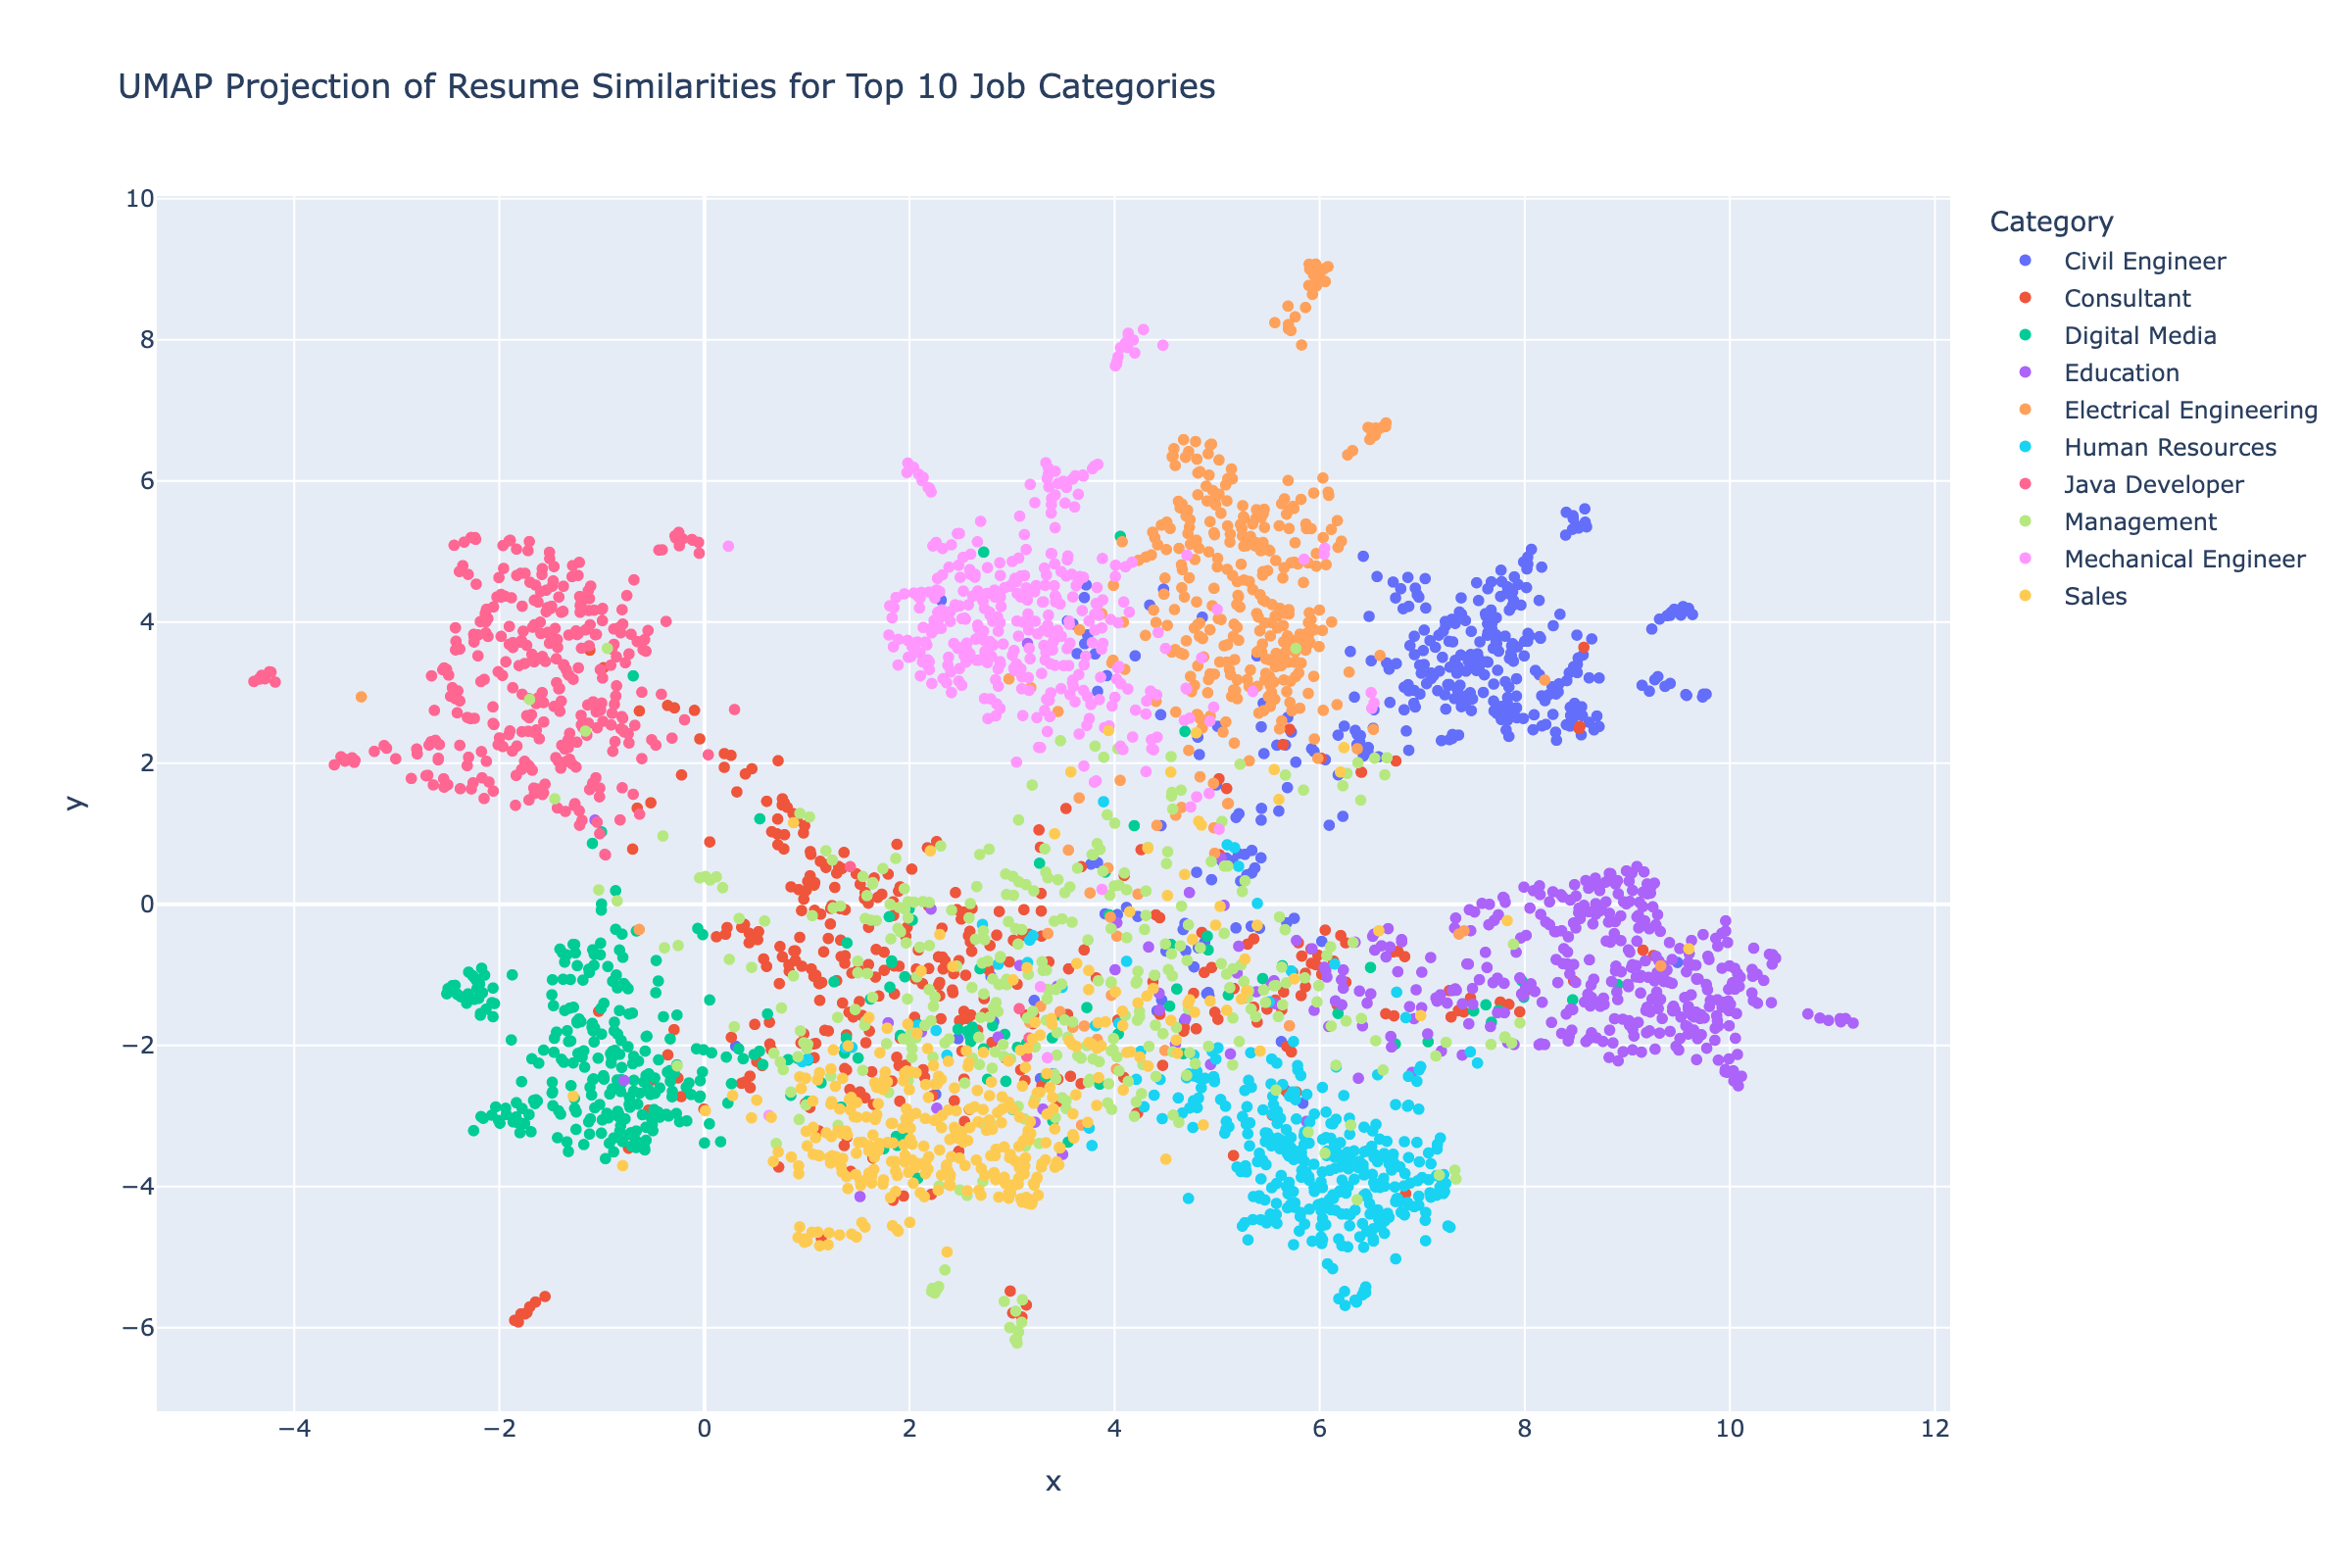

In [29]:
from IPython.display import Image, display
display(Image("figures/umap_top10_categories_nomic.png"))

In [30]:
display(df[["word_count","char_count"]]
        .describe(percentiles=[.5,.75,.9,.95])
        .round(1))

p75_chars = df["char_count"].quantile(0.75) # Calculate chunk size for splitting
chunk_size   = int(max(1500, min(6000, p75_chars))) # Chunk size
chunk_overlap= int(min(0.15 * chunk_size, 300))
print({"chunk_size": chunk_size, "chunk_overlap": chunk_overlap})


word_count  char_count
count     13322.0     13322.0
mean        655.7      4810.8
std         442.4      3218.3
min           8.0        74.0
50%         564.0      4129.0
75%         850.0      6297.0
90%        1159.0      8454.9
95%        1429.0     10378.0
max        9735.0     70035.0

{'chunk_size': 6000, 'chunk_overlap': 300}


MINIMAL PREPROCESSING FOR EMBEDDING 

In [31]:
# 3) Clean the OCR text:
#    - Ensure everything is string
#    - Replace literal \r\n and actual CRLF with \n
#    - Remove long underscores or hyphens (common resume dividers)
#    - Collapse excessive spaces
#    - Strip leading/trailing whitespace
"""df['Text'] = (
    df['Text'].astype(str)
      .str.replace(r'\\r\\n', '\n', regex=True)     # handle escaped line breaks
      .str.replace(r'\r\n', '\n', regex=True)       # handle real CRLF
      .str.replace(r'[_\-]{4,}', ' ', regex=True)   # remove long runs of underscores/hyphens
      .str.replace(r'[ \t]+', ' ', regex=True)      # collapse multiple spaces/tabs
      .str.strip()
)

# Preview
df.head(2)"""


"df['Text'] = (\n    df['Text'].astype(str)\n      .str.replace(r'\\r\\n', '\n', regex=True)     # handle escaped line breaks\n      .str.replace(r'\r\n', '\n', regex=True)       # handle real CRLF\n      .str.replace(r'[_\\-]{4,}', ' ', regex=True)   # remove long runs of underscores/hyphens\n      .str.replace(r'[ \t]+', ' ', regex=True)      # collapse multiple spaces/tabs\n      .str.strip()\n)\n\n# Preview\ndf.head(2)"

In [32]:
def mask_pii(s: str) -> str:
    s = email_rx.sub("[EMAIL]", s)
    s = phone_rx.sub("[PHONE]", s)
    s = url_rx.sub("[URL]", s) 
    return s


df["text_clean"] = df["Text"]
df["text_embed"] = df["text_clean"].map(mask_pii)

keep = df["word_count"] >= 20
df_proc = df.loc[keep].drop_duplicates(subset=["text_embed"]).reset_index(drop=True)

In [33]:
print({
    "kept_rows": len(df_proc),
    "dropped_very_short": int((~keep).sum()),
    "dropped_exact_dups": int(len(df) - (~keep).sum() - len(df_proc))
})


{'kept_rows': 12102, 'dropped_very_short': 9, 'dropped_exact_dups': 1211}


In [34]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12102 entries, 0 to 12101
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Category    12102 non-null  object
 1   Text        12102 non-null  object
 2   Resume_id   12102 non-null  object
 3   has_email   12102 non-null  bool  
 4   has_phone   12102 non-null  bool  
 5   has_url     12102 non-null  bool  
 6   char_count  12102 non-null  int64 
 7   word_count  12102 non-null  int64 
 8   text_clean  12102 non-null  object
 9   text_embed  12102 non-null  object
dtypes: bool(3), int64(2), object(5)
memory usage: 697.4+ KB


LANGCHAIN PIPELINE

In [35]:
from langchain.schema import Document

def create_langchain_documents(df_proc):
    """
    Convert your preprocessed dataframe to LangChain Documents
    """
    documents = []
    
    for idx, row in df_proc.iterrows():
        # Metadata from your schema
        metadata = {
            'resume_id': row['Resume_id'], 
            'category': row['Category'],   
            'word_count': row['word_count'],
            'char_count': row['char_count'],
            'has_email': row['has_email'],
            'has_phone': row['has_phone'],
            'has_url': row['has_url'],
            'source': f"resume_{row['Resume_id']}",
            'index': idx
        }
        
        # Use masked text for embeddings
        doc = Document(
            page_content=row['text_embed'],  
            metadata=metadata
        )
        
        documents.append(doc)
    
    return documents

documents = create_langchain_documents(df_proc)

print(f"Created {len(documents)} documents")
print(f"Sample metadata: {documents[0].metadata}")
print(f"Content preview: {documents[0].page_content[:200]}...")

Created 12102 documents
Sample metadata: {'resume_id': '740689693233207398', 'category': 'Accountant', 'word_count': 199, 'char_count': 1573, 'has_email': False, 'has_phone': True, 'has_url': False, 'source': 'resume_740689693233207398', 'index': 0}
Content preview: ﻿________________

EDUCATION
OMBA - Executive Leadership University of Texas
[PHONE]
O Bachelor of Science in Accounting Richland College
[PHONE]
TRAINING & CERTIFICATIONS
Certified Management...


In [36]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Configure your splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=6000,
    chunk_overlap=300,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

# Apply to your documents
split_documents = splitter.split_documents(documents)

print(f"Original resumes: {len(documents)}")
print(f"After splitting: {len(split_documents)} chunks")
print(f"Example split:")
print(split_documents[0].page_content[:500])  # preview first chunk
print("\nMetadata carried over:", split_documents[0].metadata)

Original resumes: 12102
After splitting: 15935 chunks
Example split:
﻿________________

EDUCATION
OMBA - Executive Leadership University of Texas
[PHONE]
O Bachelor of Science in Accounting Richland College
[PHONE]
TRAINING & CERTIFICATIONS
Certified Management Accountant (CMA)
Certified Financial Modeling and Valuation Analyst
Compliance and Anti-Money Laundering (09/2016) American Institute of Banking
Certified Public Account (CPA)
Lean Six Sigma Green Belt Certified
Trade Products Financial Regulations (08/2016) American Institute of Banking
ACHI

Metadata carried over: {'resume_id': '740689693233207398', 'category': 'Accountant', 'word_count': 199, 'char_count': 1573, 'has_email': False, 'has_phone': True, 'has_url': False, 'source': 'resume_740689693233207398', 'index': 0}


In [37]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'mps'},  # Apple Silicon GPU
    encode_kwargs={'normalize_embeddings': True}
)

/var/folders/k7/w3wlkgdj2bdd17bdg7w4fvdc0000gn/T/ipykernel_99113/3573390103.py:2: LangChainDeprecationWarning:

The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.



In [38]:
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# 1. Define your splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=6000,
    chunk_overlap=300,
    length_function=len
)

# 2. Build pooled (average) embeddings
resume_docs = []
resume_vectors = []

for idx, row in df_proc.iterrows():
    # Split this resume into chunks
    chunks = splitter.split_text(row["text_embed"])
    
    if not chunks:
        continue
    
    # Embed each chunk
    vectors = embeddings.embed_documents(chunks)
    avg_vector = np.mean(vectors, axis=0)  # average pooling
    
    # Store the pooled embedding and metadata
    resume_vectors.append(avg_vector.tolist())
    resume_docs.append(Document(
        page_content=row["text_embed"],  # full masked text (not chunked)
        metadata={
            "resume_id": row["Resume_id"],
            "category": row["Category"],
            "word_count": row["word_count"],
            "char_count": row["char_count"]
        }
    ))

print(f" Collapsed {len(df_proc)} resumes → {len(resume_docs)} unique averaged embeddings")

 Collapsed 12102 resumes → 12102 unique averaged embeddings


In [39]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from collections import OrderedDict
import os

# Step 1: Set up embeddings (your familiar model)
print("Loading embedding model...")
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'mps'},  # Apple Silicon GPU
    encode_kwargs={'normalize_embeddings': True}
)

# Step 2: Create Chroma vector store
print("Creating Chroma vector store...")
vectorstore = Chroma.from_documents(
    documents=split_documents,
    embedding=embeddings,
    persist_directory="./chroma_db",
    collection_name="resume_collection"
)

print(f"Created Chroma vector store with {len(split_documents)} documents")
print(f" Database saved to: ./chroma_db")

# Step 3: Add deduplication function
def deduplicate_by_resume_id(docs, k=5):
    
    #Remove duplicate resumes, keeping only the highest-scoring chunk per resume_id
    
    seen_resumes = OrderedDict()
    
    for doc in docs:
        resume_id = doc.metadata['resume_id']
        if resume_id not in seen_resumes:
            seen_resumes[resume_id] = doc
        # If we've seen this resume before, we keep the first one (highest scoring)
    
    # Return up to k unique resumes
    return list(seen_resumes.values())[:k]

# Step 4: Test with deduplication
print("\n Testing vector store with deduplication...")
test_query = "Python developer with machine learning experience"

# Get more results initially (since we'll deduplicate)
raw_results = vectorstore.similarity_search(test_query, k=50)
unique_results = deduplicate_by_resume_id(raw_results, k=5)

print(f"Query: '{test_query}'")
print(f"Raw results: {len(raw_results)} chunks")
print(f"Unique resumes: {len(unique_results)}")
print("\nTop 3 unique matches:")

for i, doc in enumerate(unique_results):
    print(f"\n{i+1}. Category: {doc.metadata['category']}")
    print(f"   Resume ID: {doc.metadata['resume_id']}")
    print(f"   Word count: {doc.metadata['word_count']}")
    print(f"   Content preview: {doc.page_content[:150]}...")

Loading embedding model...
Creating Chroma vector store...
Created Chroma vector store with 15935 documents
 Database saved to: ./chroma_db

 Testing vector store with deduplication...
Query: 'Python developer with machine learning experience'
Raw results: 50 chunks
Unique resumes: 5

Top 3 unique matches:

1. Category: Python Developer
   Resume ID: 11832465098196346861
   Word count: 924
   Content preview: ﻿________________

JESSICA CLAIRE
100 Montgomery St. 10th Floor⚫ (555) 432-1000⚫ [EMAIL]
Summary
Adaptable professional with 6+ years of experien...

2. Category: Python Developer
   Resume ID: 13043118152410020977
   Word count: 691
   Content preview: ﻿________________

JESSICA CLAIRE
[EMAIL]
(555) 432-1000
Montgomery Street, San Francisco, CA 94105
PROFESSIONAL SUMMARY
• Overall, 8 years of ...

3. Category: Python Developer
   Resume ID: 6619240792532198151
   Word count: 352
   Content preview: ﻿________________

Nonie Berardelli
Python Developer
• Profile
Python Developer wi

In [40]:
from langchain_community.vectorstores import Chroma

# Prepare IDs & metadata
ids = [doc.metadata["resume_id"] for doc in resume_docs]
metadatas = [doc.metadata for doc in resume_docs]
texts = [doc.page_content for doc in resume_docs]

# Create Chroma store
vectorstore = Chroma(
    collection_name="resume_collection_avg",
    embedding_function=embeddings,
    persist_directory="./chroma_db_avg"   # database dir
)

# Insert in batches
batch_size = 2000
for start in range(0, len(resume_docs), batch_size):
    end = start + batch_size
    print(f"Adding resumes {start}–{end}...")
    vectorstore._collection.add(
        embeddings=resume_vectors[start:end],
        documents=texts[start:end],
        metadatas=metadatas[start:end],
        ids=ids[start:end]
    )

# Persist to disk
vectorstore.persist()
print(f"✅ Stored & persisted {len(resume_docs)} resumes in './chroma_db_avg'")

/var/folders/k7/w3wlkgdj2bdd17bdg7w4fvdc0000gn/T/ipykernel_99113/3006492340.py:9: LangChainDeprecationWarning:

The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.



Adding resumes 0–2000...
Adding resumes 2000–4000...
Adding resumes 4000–6000...
Adding resumes 6000–8000...
Adding resumes 8000–10000...
Adding resumes 10000–12000...
Adding resumes 12000–14000...
✅ Stored & persisted 12102 resumes in './chroma_db_avg'


/var/folders/k7/w3wlkgdj2bdd17bdg7w4fvdc0000gn/T/ipykernel_99113/3006492340.py:28: LangChainDeprecationWarning:

Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.



In [41]:
# Quick verification
print(f"Vector store contains: {vectorstore._collection.count()} documents")

# Test retrieval with your new deduplicated store
query = "Python developer with machine learning experience"
results = vectorstore.similarity_search(query, k=3)

print(f"\nQuery: '{query}'")
print("Results from deduplicated store:")
for i, doc in enumerate(results):
    print(f"\n{i+1}. Category: {doc.metadata['category']}")
    print(f"   Resume ID: {doc.metadata['resume_id']}")
    print(f"   Word count: {doc.metadata['word_count']}")
    print(f"   Content preview: {doc.page_content[:150]}...")

Vector store contains: 12102 documents

Query: 'Python developer with machine learning experience'
Results from deduplicated store:

1. Category: Python Developer
   Resume ID: 13043118152410020977
   Word count: 691
   Content preview: ﻿________________

JESSICA CLAIRE
[EMAIL]
(555) 432-1000
Montgomery Street, San Francisco, CA 94105
PROFESSIONAL SUMMARY
• Overall, 8 years of ...

2. Category: Python Developer
   Resume ID: 6619240792532198151
   Word count: 352
   Content preview: ﻿________________

Nonie Berardelli
Python Developer
• Profile
Python Developer with 1 year of professional experience in developing robust, effi...

3. Category: Python Developer
   Resume ID: 9133305378179978659
   Word count: 302
   Content preview: ﻿________________

Blaire Gothelf Python Developer
Details
[EMAIL] (980) 813-5682 Des Moines, IA
Profile
Driven Python Developer with 1 year of ...


In [42]:
# Filter to engineering resumes only
engineering_docs = [doc for doc in resume_docs 
                   if doc.metadata["category"].lower() == "mechanical engineer" 
                   or doc.metadata["category"].lower() == "electrical engineer" 
                   or doc.metadata["category"].lower() == "civil engineer"]

print(f"Found {len(engineering_docs)} engineering resumes")

Found 648 engineering resumes


In [43]:
consultant_docs = [doc for doc in resume_docs 
                   if doc.metadata["category"].lower() == "consultant" ]

print(f"Found {len(consultant_docs)} consultant resumes")

Found 343 consultant resumes


In [44]:
sales_docs = [doc for doc in resume_docs 
                   if doc.metadata["category"].lower() == "sales" ]

print(f"Found {len(sales_docs)} sales resumes")

Found 343 sales resumes


Using NVIDIA models to extract skills

In [85]:
import os
import json
import pandas as pd
from tqdm.auto import tqdm
import openai
from pathlib import Path


In [86]:
from openai import OpenAI

# Initialize NVIDIA API client
client = OpenAI(
    api_key="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",  # NVIDIA key #gpt - 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
    base_url="https://integrate.api.nvidia.com/v1"
)

# Define model to use
MODEL_NAME = "meta/llama-3.1-70b-instruct"

In [87]:
# -------------------------------------------------
# 2️⃣  Use the existing DataFrame df_proc
# -------------------------------------------------

# Create a new DataFrame from df_proc with required columns
# Create a new DataFrame from engineering_docs
df = pd.DataFrame([{
    'CV_ID': doc.metadata['resume_id'],  # Extract 'resume_id' from metadata
    'Category': doc.metadata['category'],  # Extract 'category' from metadata
    'Text': doc.page_content  # Extract the full text content
} for doc in sales_docs]).fillna("")

print(f"✅ Loaded {len(df)} resumes")
display(df.head())


✅ Loaded 343 resumes


CV_ID Category  \
0  12380415759381592040    Sales   
1    544701498867182587    Sales   
2  11103930623570102436    Sales   
3  12716733773860109461    Sales   
4  13640034710685195300    Sales   

                                                Text  
0  ﻿________________\r\n\r\n·\r\nBrenda Charles\r...  
1  ﻿________________\r\n\r\nSample Resume for a S...  
2  ﻿________________\r\n\r\nGEORGE REDMOND\r\n10 ...  
3  ﻿________________\r\n\r\nMarvin Petersen\r\nSa...  
4  ﻿________________\r\n\r\nJill Johnson\r\nAWARD...

In [88]:
PROMPT_TEMPLATE = """
You are an expert resume analyst.  
Extract **both** high‑level skills (broad job roles) and low‑level skills (specific tools, libraries, techniques) **and** the following metadata from the resume text that follows.

Return **only valid JSON** with this schema:

{{
  "high_level_skills": [list of strings],
  "low_level_skills": [list of strings],
  "metadata": {{
    "education": [list of strings],
    "certifications": [list of strings],
    "years_of_experience": "string",
    "job_titles": [list of strings],
    "domains": [list of strings]
  }}
}}

Resume text:
\"\"\"{Text}\"\"\"
"""


In [89]:
from openai import OpenAI, APIError, RateLimitError
import json, time
from tqdm import tqdm  


# Reusable call function
def call_model(prompt: str, max_tokens: int = 800, model: str = MODEL_NAME) -> dict:
    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are an expert resume analyst."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            raw = response.choices[0].message.content.strip()
            if "```" in raw:
                raw = raw.split("```")[1].strip()
            return json.loads(raw)

        except json.JSONDecodeError as e:
            print(" JSON decode error. Raw output:", raw[:300])
            raise e
        except RateLimitError:
            wait = 2 ** attempt
            print(f"⏳ Rate limit – retrying in {wait}s...")
            time.sleep(wait)
        except APIError as e:
            print(f"⚠️ API error: {e}")
            if attempt == 2:
                raise

In [90]:
"""import json, time
from openai import OpenAI, APIError, RateLimitError

# Initialize client for NVIDIA endpoint
client = OpenAI(
    api_key="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",  # your NVIDIA key
    base_url="https://integrate.api.nvidia.com/v1"  # NVIDIA REST endpoint
)

def call_gpt_oss(prompt: str, max_tokens: int = 800, model="llama-3.3-70b-instruct") -> dict:
    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model="llama-3.3-70b-instruct",   # NVIDIA OSS model (e.g. "gpt-oss-120b", "llama-3.1-70b-instruct")
                messages=[
                    {"role": "system", "content": "You are an expert resume analyst."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            raw = response.choices[0].message.content.strip()
            if "```" in raw:
                raw = raw.split("```")[1].strip()
            return json.loads(raw)

        except json.JSONDecodeError as e:
            print("JSON decode error. Raw output:", raw[:300])
            raise e
        except RateLimitError:
            wait = 2 ** attempt
            print(f"Rate limit – retrying in {wait}s...")
            time.sleep(wait)
        except APIError as e:
            print(f"API error: {e}")
            if attempt == 2:
                raise"""

'import json, time\nfrom openai import OpenAI, APIError, RateLimitError\n\n# Initialize client for NVIDIA endpoint\nclient = OpenAI(\n    api_key="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",  # your NVIDIA key\n    base_url="https://integrate.api.nvidia.com/v1"  # NVIDIA REST endpoint\n)\n\ndef call_gpt_oss(prompt: str, max_tokens: int = 800, model="llama-3.3-70b-instruct") -> dict:\n    for attempt in range(3):\n        try:\n            response = client.chat.completions.create(\n                model="llama-3.3-70b-instruct",   # NVIDIA OSS model (e.g. "gpt-oss-120b", "llama-3.1-70b-instruct")\n                messages=[\n                    {"role": "system", "content": "You are an expert resume analyst."},\n                    {"role": "user", "content": prompt}\n                ],\n                temperature=0.0,\n                max_tokens=max_tokens,\n            )\n            raw = response.choices[0].message.content.strip()\n            if "```"

In [91]:
""""import openai, json, time
from openai import RateLimitError, APIError

def call_gpt_oss(prompt: str, max_tokens: int = 800) -> dict:
    for attempt in range(3):
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[{"role": "system", "content": PROMPT_TEMPLATE},
                          {"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            raw = response.choices[0].message.content.strip()
            if "```" in raw:
                raw = raw.split("```")[1].strip()
            return json.loads(raw)
        
        except json.JSONDecodeError as e:
            print("JSON decode error. Raw output:", raw[:300])
            raise e
        except RateLimitError:
            wait = 2 ** attempt
            print(f"⏳ Rate limit – retrying in {wait}s...")
            time.sleep(wait)
        except APIError as e:
            print(f"API error: {e}")
            if attempt == 2:
                raise"""

'"import openai, json, time\nfrom openai import RateLimitError, APIError\n\ndef call_gpt_oss(prompt: str, max_tokens: int = 800) -> dict:\n    for attempt in range(3):\n        try:\n            response = openai.ChatCompletion.create(\n                model=model,\n                messages=[{"role": "system", "content": PROMPT_TEMPLATE},\n                          {"role": "user", "content": prompt}],\n                temperature=0.0,\n                max_tokens=max_tokens,\n            )\n            raw = response.choices[0].message.content.strip()\n            if "```" in raw:\n                raw = raw.split("```")[1].strip()\n            return json.loads(raw)\n\n        except json.JSONDecodeError as e:\n            print("JSON decode error. Raw output:", raw[:300])\n            raise e\n        except RateLimitError:\n            wait = 2 ** attempt\n            print(f"⏳ Rate limit – retrying in {wait}s...")\n            time.sleep(wait)\n        except APIError as e:\n       

In [92]:
cv_dict = {}        # final container
errors = []         # track errors

#sample_df = df.head(10)   # just 10 resumes 

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing resumes"):
    cv_id      = row["CV_ID"]
    category   = row["Category"]
    resume_txt = row["Text"]

    prompt = PROMPT_TEMPLATE.format(Text=resume_txt)

    try:
        result = call_model(prompt)
        cv_dict[cv_id] = {
            "category": category,
            "low_level_skills": result.get("low_level_skills", []),
            "high_level_skills": result.get("high_level_skills", []),
        }
    except Exception as exc:
        errors.append((cv_id, str(exc)))
        cv_dict[cv_id] = {
            "category": category,
            "low_level_skills": [],
            "high_level_skills": [],
            "error": str(exc)
        }

print(f" Finished. Extracted data for {len(cv_dict)} resumes (sample).")
if errors:
    print(f" {len(errors)} resumes raised errors. See `errors` for details.")

Processing resumes:  64%|██████▍   | 221/343 [19:34<08:43,  4.29s/it]  

 JSON decode error. Raw output: {
  "high_level_skills": [
    "Customer Service",
    "Sales",
    "Inventory Management",
    "Data Entry",
    "Banking",
    "Call Center",
    "Reception",
    "Research"
  ],
  "low_level_skills": [
    "Live Support",
    "Epic EMR",
    "Service Desk Express",
    "Multi-lined phone system",


Processing resumes: 100%|██████████| 343/343 [29:19<00:00,  5.13s/it]

 Finished. Extracted data for 343 resumes (sample).
 1 resumes raised errors. See `errors` for details.


In [93]:
OUTPUT_PATH = Path("extracted_resume_data_sales.json")
with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(cv_dict, f, ensure_ascii=False, indent=2)

print(f" Extraction saved to {OUTPUT_PATH}")


 Extraction saved to extracted_resume_data_sales.json


In [94]:
-END-

SyntaxError: invalid syntax (728166730.py, line 1)

The below code is not executed as embedding.csv and the chromaDB files are too large to commit

In [ ]:
cols = ["Resume_id","Category","text_clean","text_embed"]
df_proc[cols].to_csv("embedding.csv", index=False)


In [ ]:
# A single simple plot; keeps the notebook clean.
import matplotlib.pyplot as plt

df["word_count"].clip(upper=df["word_count"].quantile(0.99)).hist(bins=40)
plt.title("Word count per resume")
plt.xlabel("words"); plt.ylabel("count"); plt.show()
